<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/ML_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine leaning 기반의 Sampling

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 실험을 위한 기본적인 function 들...

In [4]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
#from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

In [5]:
main_figsize=(15,3)

In [6]:

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [7]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# 실험


## synthetic data의 생성 (Case #1 MI의 감소, Drift의 증가 )

+ 일반적인 Case 중의 하나, 통상 MI가 하나 감소하면 상대적으로 다른 feature의 MI가 상승하지만, 이번 Case는 상대적인 상능이 없는 경우.

In [8]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [9]:
seed_everything()

y= (np.random.normal(0.5,0.5,100) > 0.5).astype(int)
sum(y)

40

In [10]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    #sns.scatterplot(x=x[:,ix],y=y)

In [11]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
#sns.scatterplot(x=x[0:200,4],y=y[0:200])
#sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

### KS-test 통계량의 측정

In [12]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
x1    0.079411
x0    0.050887
z0    0.027068
Name: MI Scores, dtype: float64


Bucket size 200 step_size 190


100%|██████████| 190/190 [00:02<00:00, 65.63it/s]


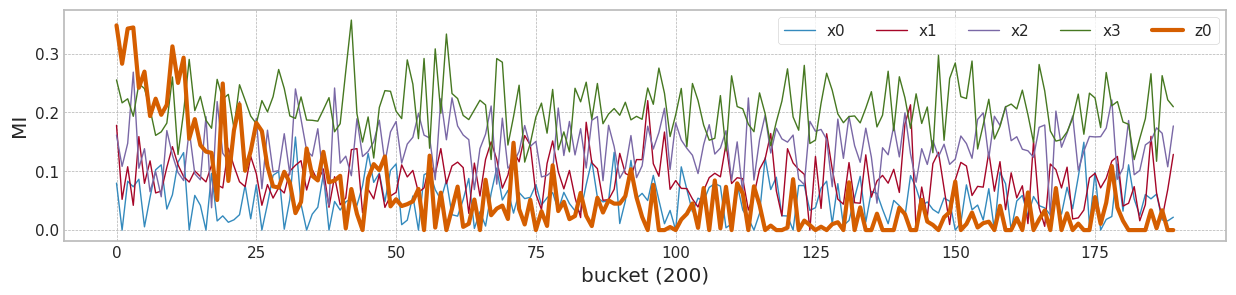

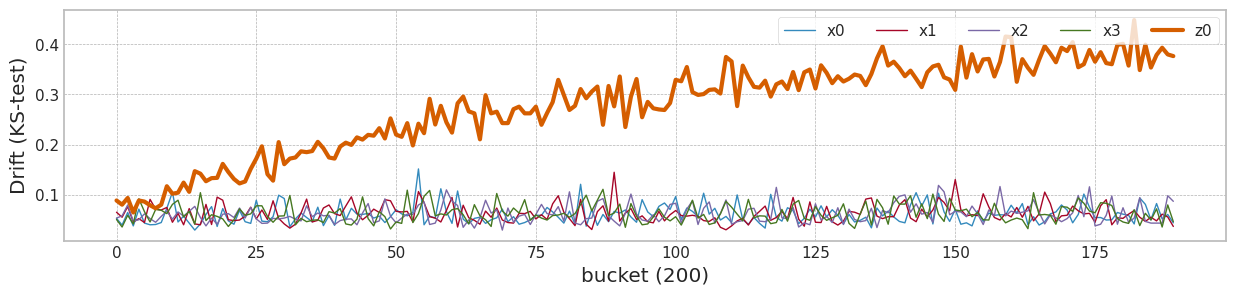

In [13]:
from tqdm import tqdm

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

bucket_size_array=[200]#[10,50,100,200]

######################## Normalization ############################
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_c1 = StandardScaler()
scaler_c1.fit(X[0:1800])
X = pd.DataFrame(scaler_c1.transform(X), columns=columns)


for bucket_size in bucket_size_array:
    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((x.shape[0]-2000)/bucket_size)

    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*bucket_size:bk*bucket_size+bucket_size], y[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X[0:1800].values,X[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    '''
    df_mis['x0'].plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=10)
    plt.show()
    df_mis['x1'].plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=10)
    plt.show()
    df_mis['x2'].plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=10)
    plt.show()
    df_mis['x3'].plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=10)
    plt.show()
    df_mis['z0'].plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=10)
    plt.show()
    '''
    plt.figure(figsize=main_figsize)
    plt.plot(df_mis[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_mis['z0'].values,linewidth=3,label='z0')
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_drf['z0'].values,linewidth=3,label='z0')
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

In [16]:
X

,x0,x1,x2,x3,z0
0,0.470248,-0.657094,0.644936,-0.385024,-0.491275
1,-0.098493,0.586148,0.837920,1.355031,0.855489
2,0.227515,1.703803,1.741631,0.321081,1.377059
3,0.936628,-1.340995,-0.438504,-0.137903,-0.814809
4,0.861016,1.212753,0.120639,0.323837,1.266538
...,...,...,...,...,...
39995,-0.878001,-1.603546,0.040948,0.434072,-3.455138
39996,-0.259746,-1.334902,-0.152821,0.351855,3.267598
39997,-0.661842,0.822949,0.806100,0.424942,0.359024
39998,0.080499,-1.616542,-1.980372,0.743351,10.020811


### ML Sampling

(4000, 5) 12


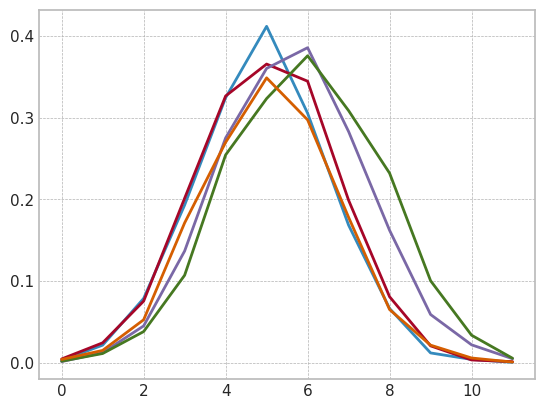

(4000, 5) 12


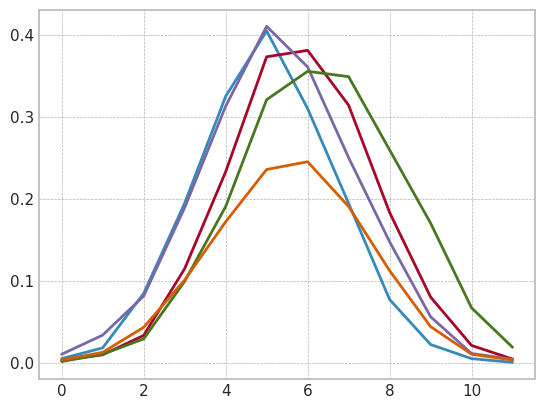

(4000, 5) 12


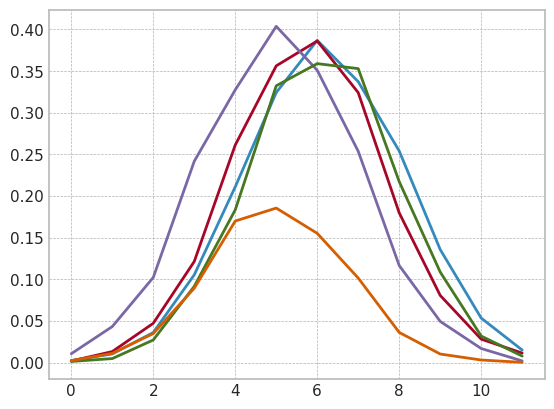

(4000, 5) 12


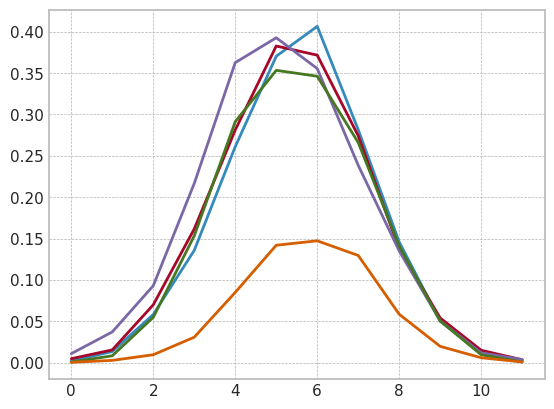

(4000, 5) 12


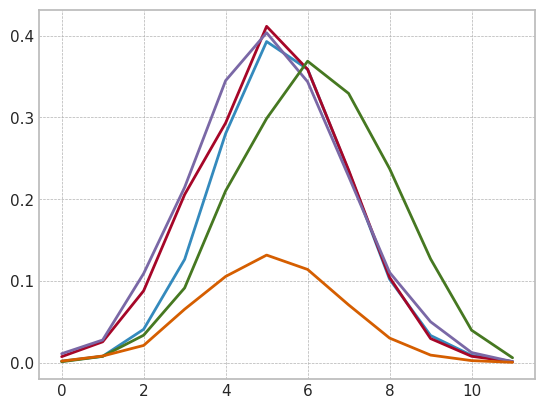

(4000, 5) 12


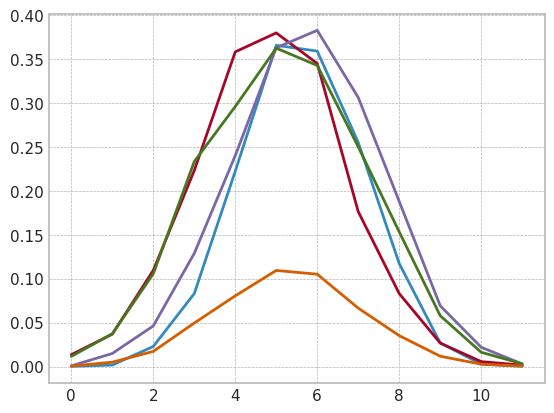

(4000, 5) 12


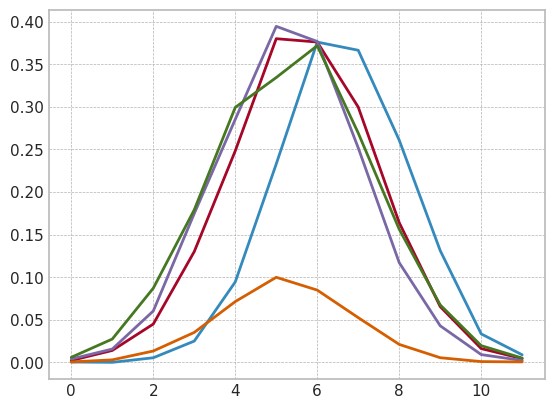

(4000, 5) 12


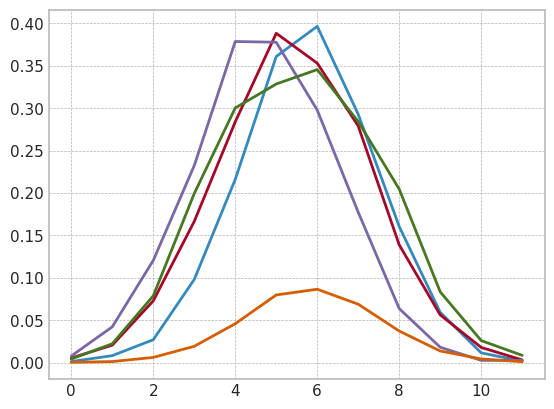

(4000, 5) 12


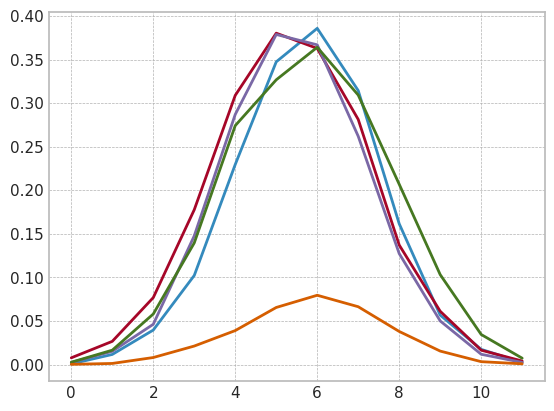

(4000, 5) 12


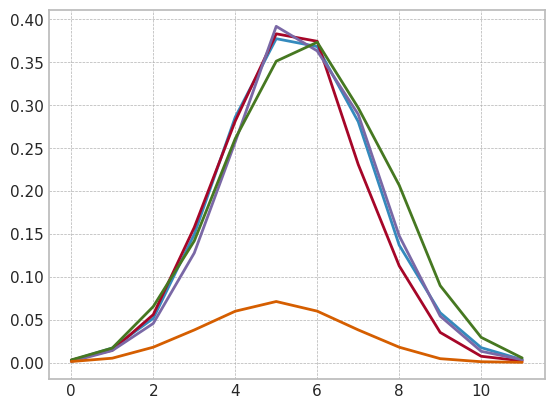

In [25]:
bucket_size = 4000
live_set = [X[i*bucket_size:i*bucket_size + bucket_size] for i in range(int(X.shape[0]/bucket_size))]
for data in live_set:
    bins = int(1+3.322*np.log10(data.shape[0]))
    print(data.shape,bins)
    for col in data.columns:
        p, bin_edge = np.histogram(data[col].values,
                                    bins=np.min([bins, len(data[col].unique())]),
                                    density=True)
        plt.plot(p)
    plt.show()
